In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from imblearn.over_sampling import KMeansSMOTE

from tqdm import tqdm
tqdm.pandas(desc="my bar!")


Bad key "text.kerning_factor" on line 4 in
/home/ryx/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/home/ryx/miniconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
dataset = pd.read_csv('../data/dataset/short_text_feat.csv')

In [3]:
dataset.label.value_counts()

0    10872
1     1329
Name: label, dtype: int64

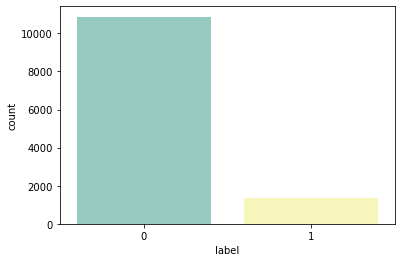

In [4]:
sns.countplot(x="label", data=dataset, palette="Set3")

In [5]:
dataset.head()

,text,label,token,char_count,n_token,jaccard_sim,levenshtein_dist
0,GantengPendekar,0,"['Ganteng', 'Pendekar']",15,2,0.285714,2.0
1,wal_hasbi,0,"['wal', 'hasbi']",9,2,0.200000,1.0
2,SMART_JABAR,0,"['SMART', 'JABAR']",11,2,0.666667,4.0
3,DiniAriyani20,0,"['Dini', 'Ariyani20']",13,2,0.500000,3.0
4,widepyp,0,['widepyp'],7,1,0.500000,4.0


In [6]:
X = dataset[['jaccard_sim', 'levenshtein_dist', 'char_count']]
y = dataset.label

## Heatmap correlation

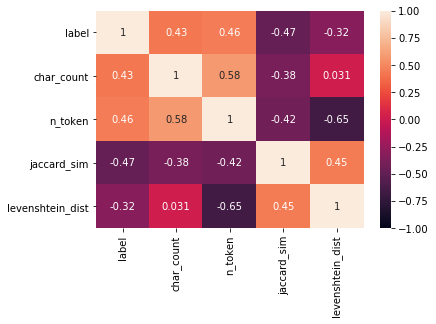

In [7]:
sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
sm = KMeansSMOTE(random_state=42, sampling_strategy='minority')
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
def model(X_train, y_train, X_test, y_test, params):    
    rf = RandomForestClassifier(random_state=42)
    clf = RandomizedSearchCV(rf, params, random_state=42, n_jobs=2,
                             scoring=['f1', 'precision'], refit='f1', verbose=1)
    search = clf.fit(X_train, y_train)
    print(search.best_params_)
    
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('ROC Score=', roc_auc_score(y_test, y_pred))
    plot_roc_curve(clf, X_test, y_test)
    plt.show()
    
    return search

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  2.0min finished


{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2175
           1       0.62      0.67      0.65       266

    accuracy                           0.92      2441
   macro avg       0.79      0.81      0.80      2441
weighted avg       0.92      0.92      0.92      2441

ROC Score= 0.8099887650159883


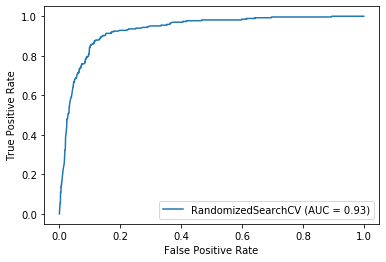

In [12]:
out = model(X_train_res, y_train_res, X_test, y_test, params=random_grid)

In [13]:
pd.DataFrame(out.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,std_test_f1,rank_test_f1,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,0.801215,0.075388,0.079780,0.009834,200,10,2,sqrt,50,True,...,0.062035,3,0.970774,0.950273,0.948746,0.954446,0.956155,0.956079,0.007824,1
1,2.848596,0.315287,0.226740,0.026968,600,10,4,sqrt,90,False,...,0.062494,5,0.971451,0.948718,0.948746,0.954446,0.956180,0.955908,0.008328,2
2,2.920241,0.335591,0.233219,0.027304,600,2,2,auto,60,False,...,0.062586,6,0.969889,0.945109,0.946652,0.953399,0.952725,0.953555,0.008792,10
3,5.639357,0.532483,0.531112,0.050598,1400,5,1,sqrt,30,True,...,0.063964,7,0.973515,0.945623,0.949264,0.951340,0.954318,0.954812,0.009771,7
4,4.907923,0.538119,0.390652,0.046394,1000,10,1,auto,80,False,...,0.063989,10,0.972735,0.945623,0.952355,0.952877,0.950975,0.954913,0.009275,6
5,1.961843,0.217702,0.159443,0.017997,400,10,1,sqrt,60,False,...,0.064022,9,0.972735,0.946137,0.952851,0.953399,0.950948,0.955214,0.009126,5
6,9.735488,1.120947,0.762767,0.089085,2000,2,2,auto,50,False,...,0.062438,8,0.969889,0.945623,0.946652,0.953399,0.952540,0.953621,0.008699,9
7,0.735650,0.053846,0.068123,0.005022,200,5,2,sqrt,10,True,...,0.060285,1,0.971003,0.947684,0.948746,0.954446,0.954571,0.955290,0.008352,4
8,4.654142,0.420971,0.435110,0.049473,1200,2,4,auto,100,True,...,0.061293,2,0.970126,0.951834,0.948746,0.952877,0.954036,0.955524,0.007510,3
9,7.936162,0.724713,0.736679,0.079734,2000,5,2,auto,50,True,...,0.061008,4,0.970889,0.945623,0.947197,0.953922,0.956278,0.954782,0.008987,8


In [14]:
out.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [15]:
import joblib
joblib.dump(out.best_estimator_, '../model/social_political_clf.pkl')

['../model/social_political_clf.pkl']